<a href="https://colab.research.google.com/github/gusmarlaj/Machine_Learning_Ideas/blob/master/Sentiment_Analysis_of_Amazon_Alexa_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Sentiment Analysis of Amazon Alexa with DistilBERT and Tensorflow

**About the Data:** This dataset consists of a nearly 3000 Amazon customer reviews (input text), star ratings, date of review, variant and feedback of various amazon Alexa products like Alexa Echo, Echo dots, Alexa Firesticks etc. for learning how to train Machine for sentiment analysis.

With this data is possible to analyze Amazon’s Alexa product discovering insights into consumer reviews and assist with machine learning models.

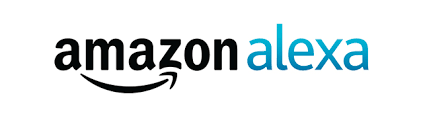


Source: Extracted from Amazon's website









In [ ]:
!pip install tensorflow transformers

In [ ]:
# To finetune transformer model, we need following libraries
import tensorflow as tf
from tensorflow.keras import activations, optimizers, losses
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

# To save our trained model, we import pickle library
import pickle

# To pre-process, we need following libraries
import pandas as pd
import numpy as np
import seaborn as sns

# To explre and visualize data, we need following libraries
import matplotlib.pyplot as plt
import plotly.express as px



## **Binary text classifier with 🤗Transformers!**

Exploration of the sentiment analysis using `TFDistilBertForSequenceClassification` from the HuggingFace🤗Transformers library.

The classification will be on the reviews as positive or negative based on the sentiment of the reviews

**The notebook has 5 steps:**
1. Preprocessing the data
2. Fine-tuning the model
3. Testing the model
4. Using the fine-tuned model to predict new samples
5. Saving and loading the model for future use



- BERT (and its variants like DistilBERT) can be a great tool in a situation when we don't have huge amount of data to train from scratch.
- Also, training the model from scratch is computationally expensive, thus transfer learning comes handy.
- It is recommended to have atleast 200+ training samples while finetuning an NLP pre-trained model

**Why DistilBERT?**

- DistilBERT is a lighter and faster version of BERT in simple terms.
- It consists of 6 encoder blocks (BERT had 12 encoder blocks stacked up). Inspite of this, it retains 97% of the functionality provided by BERT
- To summarize, DistlBERT is 40% smaller than original BERT base model, and it 60% faster to train than the original BERT model.
- Note: DisltiBERT was trained using only masked language modeling (and not next sentence prediction)

Link to the dataset: https://www.kaggle.com/datasets/sid321axn/amazon-alexa-reviews

Link to the presentation: https://docs.google.com/presentation/d/1jw5ZeDzsMAYCBPDcru8ZiL8A878SD8BLwEL0OZhd_L8/edit?usp=sharing


- Note: **Go to Runtime -> Select Change runtime -> Choose GPU under hardware accelerator.**

This will enable you to use Google colab's GPU for better processing power

### **Step 1: Load & Explore the Data**

In [ ]:
#df=pd.read_csv('amazon_alexa.tsv',sep='\t')
# .tsv file indicates tab delimited files. Hence, we pass the sep='\t' argument to indicate the file is separated by tabs and not commas

df=pd.read_csv('amazon_alexa.tsv',sep='\t')

In [ ]:
# Read top 5 rows of the dataset
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [ ]:
df.iloc[111:112,3:5]

,verified_reviews,feedback
111,Sound is terrible if u want good music too get...,0


In [ ]:
df[df['feedback'] == 1].head(10)

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1
5,5,31-Jul-18,Heather Gray Fabric,I received the echo as a gift. I needed anothe...,1
6,3,31-Jul-18,Sandstone Fabric,"Without having a cellphone, I cannot use many ...",1
7,5,31-Jul-18,Charcoal Fabric,I think this is the 5th one I've purchased. I'...,1
8,5,30-Jul-18,Heather Gray Fabric,looks great,1
9,5,30-Jul-18,Heather Gray Fabric,Love it! I’ve listened to songs I haven’t hear...,1


In [ ]:
df[df['feedback']==0].head()

,rating,date,variation,verified_reviews,feedback
46,2,30-Jul-18,Charcoal Fabric,"It's like Siri, in fact, Siri answers more acc...",0
111,2,30-Jul-18,Charcoal Fabric,Sound is terrible if u want good music too get...,0
141,1,30-Jul-18,Charcoal Fabric,Not much features.,0
162,1,30-Jul-18,Sandstone Fabric,"Stopped working after 2 weeks ,didn't follow c...",0
176,2,30-Jul-18,Heather Gray Fabric,Sad joke. Worthless.,0


In [ ]:
# Printing shape of dataset --> 3150 rows, 5 columns
df.shape

(3150, 5)

In [ ]:
df['feedback'].value_counts()

1    2893
0     257
Name: feedback, dtype: int64

1.1 **Check whether data is balanced or not**
- Before proceeding with model training, it is very important to check the class distribution in classification problems.

In [ ]:
# Plot count of feedback
df_plot = df.groupby(by=['feedback']).size().reset_index(name='count')
fig = px.bar(df_plot, x='feedback', y='count', color='feedback', color_discrete_map={0: 'yellow', 1: 'green'})
fig.show()

<Axes: xlabel='feedback', ylabel='count'>

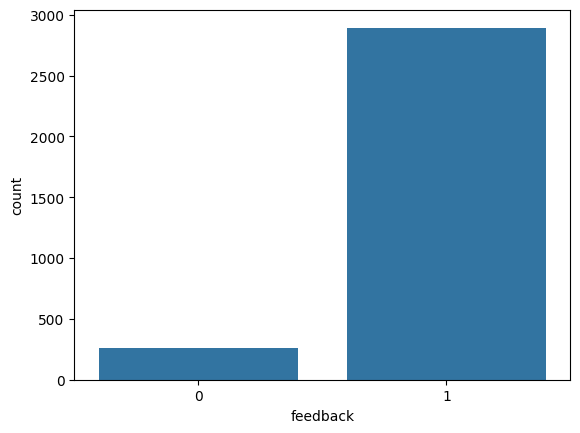

In [ ]:
#Similar plot can be done using seaborn library
sns.countplot(x=df['feedback'])

- We can notice that there are lot more positive reviews than negative reviews in our given data.
- This is what happens in real life scenario

**Insights:**
1. People tend to not give negative reviews. There are very few instances where customers express negative reviews
2. Or the product by default is good enough and doesn't have many negative reviews.

- Now, before we start training our model, it is necessary to handle this issue of class imbalance, otherwise, out model would produce biased predictions.
- To handle this issue, we sub-sample the majority class and choose only those number of samples from majority class as many are present in the minority class

In [ ]:
# Check the shape of dataframe having only negative reviews i.e. feedback=0
df[df['feedback']==0].shape

(257, 5)

In [ ]:
# Check the shape of dataframe having only positive reviews i.e. feedback=1
df[df['feedback']==1].shape

(2893, 5)

- As we can see here, we have only 257 negative reviews, where as there are 2893 positive reviews.
- Hence, to have balanced distribution of classes, we will downsample positive reviews by randomly selecting any 257 positive reviews.
- This is acheived by using dataframe.sample() function

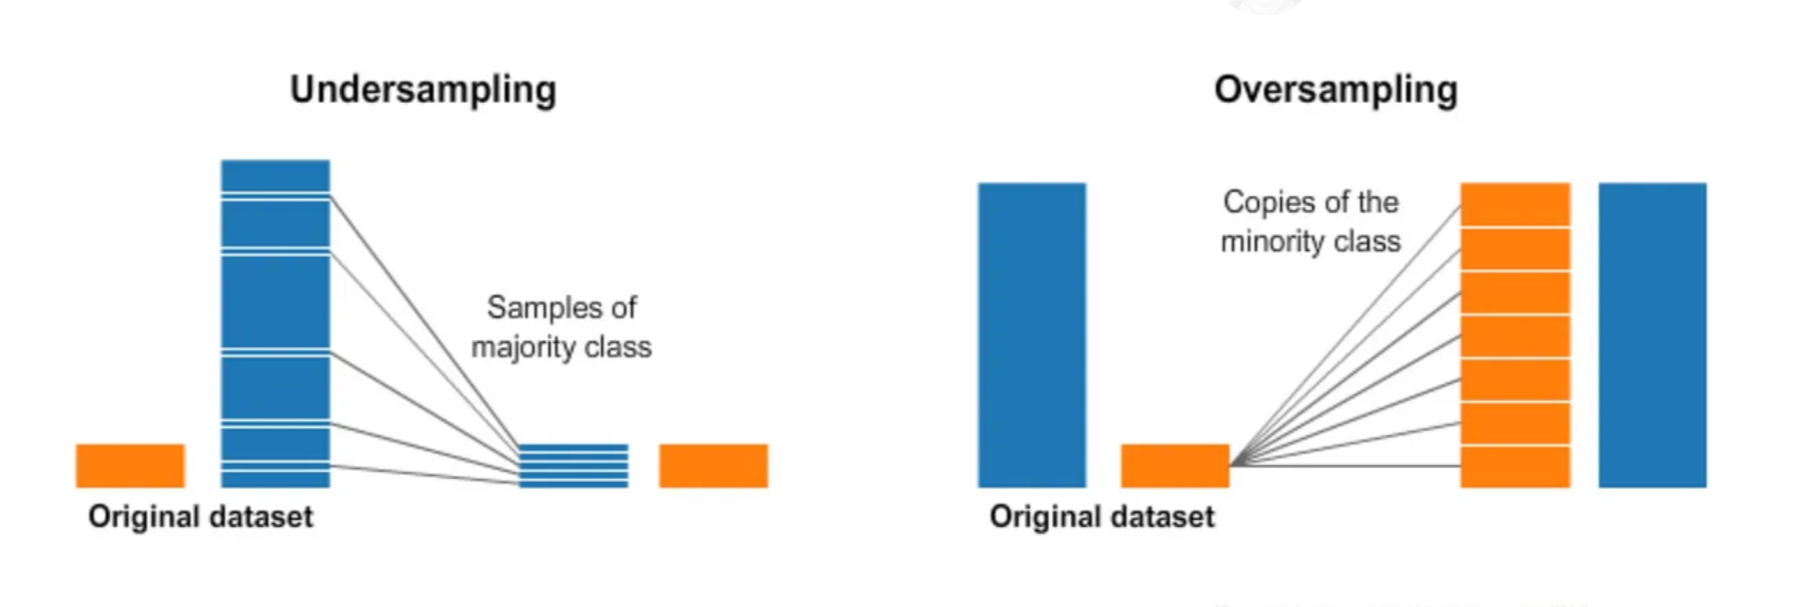

In [ ]:
# Create a dataframe with only negative reviews
df_negative=df[df['feedback']==0]
# Create a dataframe with only positive reviews
df_positive=df[df['feedback']==1]

In [ ]:
df_negative['verified_reviews'].iloc[4]

'Sad joke. Worthless.'

In [ ]:
# Check number of rows of negative reviews
df_negative.shape[0]

257

In [ ]:
# Down sample positive reviews to match number of negative reviews
df_positive_downsampled=df_positive.sample(df_negative.shape[0])
df_positive_downsampled.shape

(257, 5)

In [ ]:
# Create a balanced dataset of equal number of positive and negative reviews
df_balanced=pd.concat([df_positive_downsampled,df_negative],axis=0)
df_balanced.shape

(514, 5)

In [ ]:
df_plot = df_balanced.groupby(by=['feedback']).size().reset_index(name='count')

# Crear el gráfico de barras con Plotly Express y asignar colores
fig = px.bar(df_plot, x='feedback', y='count', color='feedback', color_discrete_map={0: 'yellow', 1: 'green'})

# Mostrar el gráfico
fig.show()

 **1.2 Check length of reviews**
- Another important step is to check the length of reviews.
- This is an important step, becuase while preparing data to pass to the BERT/ DistilBERT model, we need to specify the number of tokens to consider.
- Number of tokens is an important parameter in finetuning the language models and training time also depends on the number of tokens

In [ ]:
df_balanced['review_length']=df_balanced['verified_reviews'].apply(lambda x: len(x.split()))

In [ ]:
df_balanced.shape

(514, 6)

In [ ]:
fig = px.histogram(df_balanced, x='review_length', title='Review Length', color_discrete_sequence=['yellow'])
# Mostrar el histograma
fig.show()

In [ ]:
# Converting dataframe series object into list
x=df_balanced['verified_reviews'].to_list()
x[0:5]

["Already owning a couple of Echos, I was frustrated that I couldn’t also use them as intercoms. Finally Amazon enables the “drop-in” feature so now I can use my Echos to reach out to family in remote parts of the house (and teenagers who insist they never heard me yelling at them to come down to dinner).As for its other features, we mainly use our Echos for the standard stuff: playing music, setting alarms, answering questions, etc. It's not the life-changing home device Amazon would have you believe, but it is convenient to have around. This refurb saved me a few bucks, looks and works the same as the other brand-new ones.",
 'Great product.  Like the apps that I can connect to it.',
 'like google better',
 "So far so good.  Neat to have a visual version of alexa's responses. Nice to see the lyrics of music you are listening to.  Flash briefings have good videos.  Speaker is much better than a dot but not the highest quality",
 'I expected to have access to more current movie instead

In [ ]:
# Converting dataframe series object into list
y=df_balanced['feedback'].to_list()

In [ ]:
y[0:5]

[1, 1, 1, 1, 1]

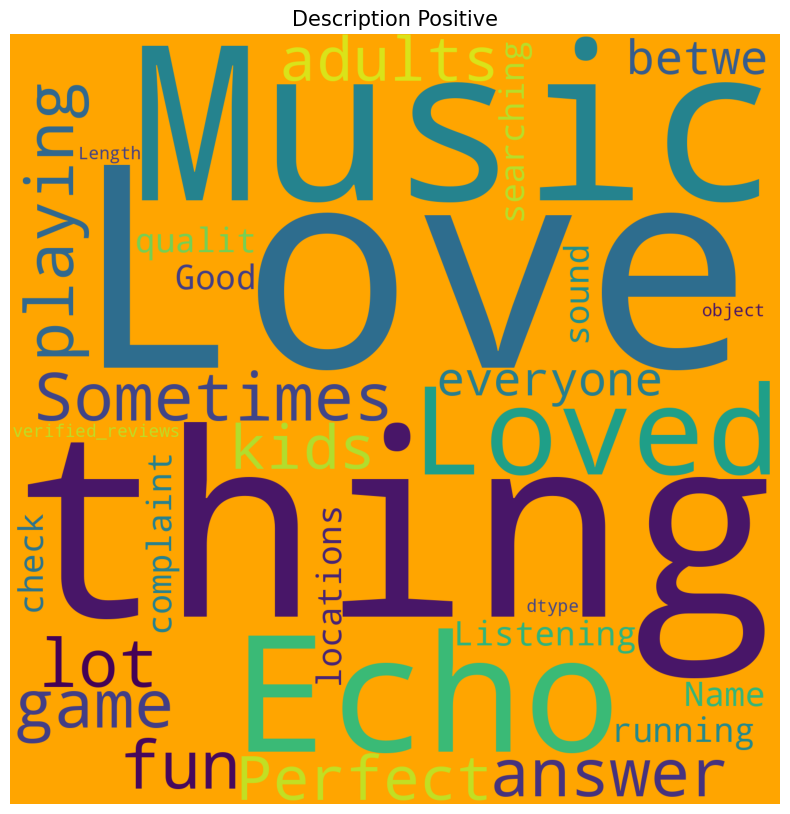

In [ ]:
from wordcloud import WordCloud

positive = df[df['feedback'] == 1]
positive

plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('fast')

wc = WordCloud(background_color = 'orange', width = 1500, height = 1500).generate(str(positive['verified_reviews']))
plt.title('Description Positive', fontsize = 15)

plt.imshow(wc)
plt.axis('off')
plt.show()

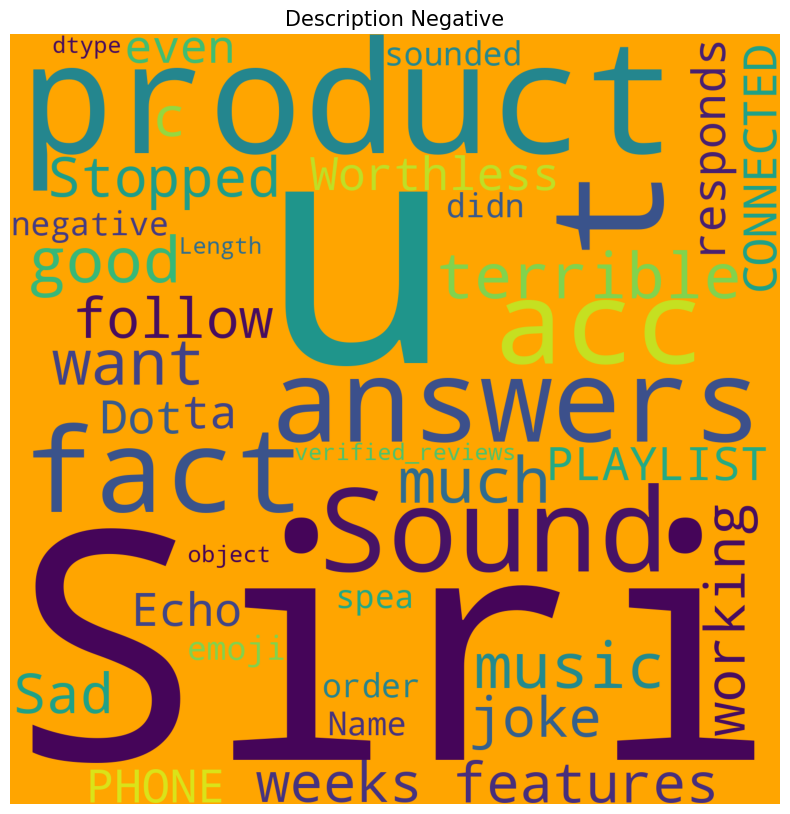

In [ ]:
negative = df[df['feedback'] == 0]
negative

plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('fast')

wc = WordCloud(background_color = 'orange', width = 1500, height = 1500).generate(str(negative['verified_reviews']))
plt.title('Description Negative', fontsize = 15)

plt.imshow(wc)
plt.axis('off')
plt.show()

**### Step 2. Preprocessing the data**

Since we are using the [DisitlBERT](https://huggingface.co/transformers/model_doc/distilbert.html) model, the first preprocessing step is to convert each review string in our dataset into a tuple containing the review's [input ids](https://huggingface.co/transformers/glossary.html#input-ids) and [attention masks](https://huggingface.co/transformers/glossary.html#attention-mask) (click the links to learn what these mean!). Luckily, these can easily be computed using the [DistilBertTokenizer](https://huggingface.co/transformers/model_doc/distilbert.html#distilberttokenizer) from 🤗Transformers.

Below is an example usage of this tokenizer on the first review. Here `MAX_LEN` specifies the length of each tokenized review. If a tokenized review is shorter than `MAX_LEN`, then it is padded with zeros. If a tokenized review is greater than `MAX_LEN`, then it is truncated (this is why we have `truncation=True` and `padding=True`).

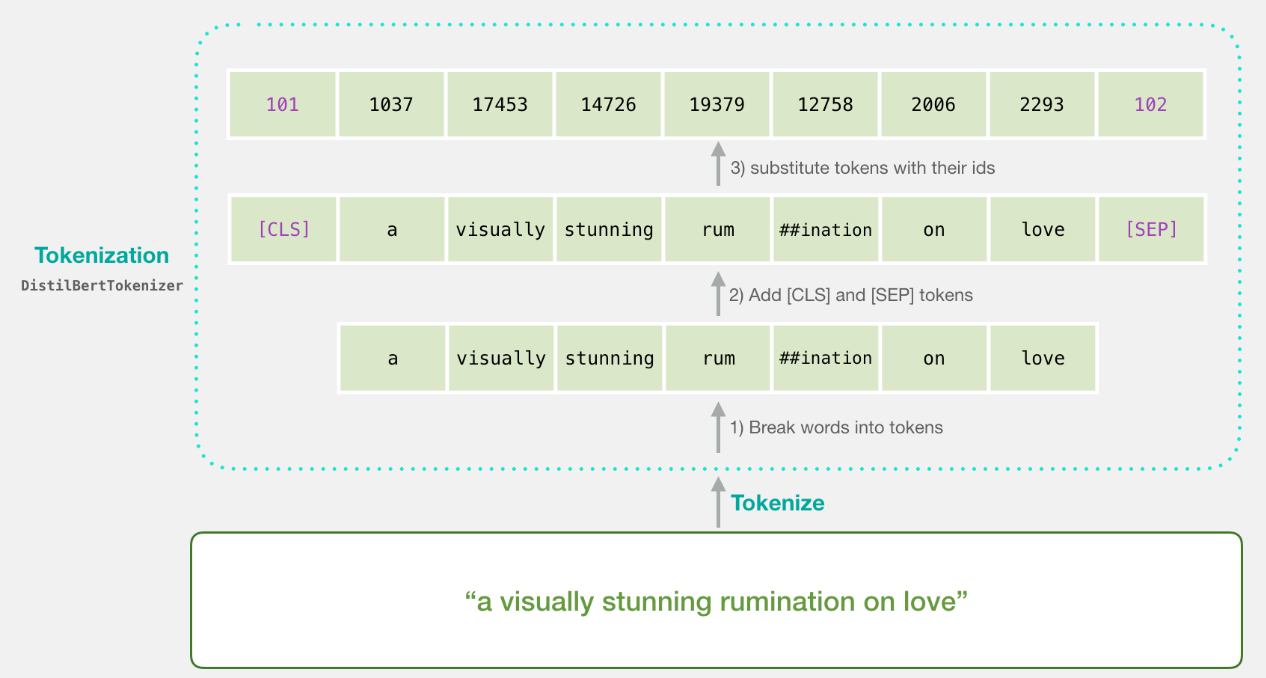

Image source: http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/


In [ ]:
MODEL_NAME = 'distilbert-base-uncased'
MAX_LEN = 50 # this is a hyper-parameter

review = "Best thing I've invested in a while thank you so much 😁😁😁😁"

tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

inputs = tokenizer(review, max_length=MAX_LEN, truncation=True,padding='max_length')


- [CLS] stands for classifcation and indicates the start of an input sequence to the model. It always has token_id as 101
- [SEP] stands for separation and indicates the end of 1st input sequence to the model. It always has token_id as 102
- [UNK] stands for unkown. Any emojis or vocalulary not known to BERT/ DistilBERT tokenizer is represented by [UNK]

In [ ]:
tokenized_words=tokenizer.convert_ids_to_tokens(inputs["input_ids"])
print(tokenized_words)

['[CLS]', 'best', 'thing', 'i', "'", 've', 'invested', 'in', 'a', 'while', 'thank', 'you', 'so', 'much', '[UNK]', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [ ]:
print(f'review: \'{review}\'')
print(f'input ids: {inputs["input_ids"]}')
print(f'attention mask: {inputs["attention_mask"]}')

review: 'Best thing I've invested in a while thank you so much 😁😁😁😁'
input ids: [101, 2190, 2518, 1045, 1005, 2310, 11241, 1999, 1037, 2096, 4067, 2017, 2061, 2172, 100, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


- **Input Ids**: Numeric vector representation of each word in the input sequence
- **Attention Masks**: Indicates the model which input tokens the model should pay attnetion to and which input tokens can be ignored. These input tokens to be ingonred as usually padding tokens.
- Value of 1 in attention mask indicates input_id contains a a valid token at that position, where as value of 0 in attention mask indicates that input_id contains a padded token at the corresponding position
- Not all reviews will have a length of 50 words. Hence smaller reviews will contain only few input ids and reamaining vacant words are padded with 0s.

Now we must apply this transformation to each review in our corpus. To do this we define a function `construct_encodings`, which maps the tokenizer to each review and aggregates them in `encodings`:

In [ ]:
def construct_encodings(x, tokenizer, max_len, trucation=True, padding=True):
    return tokenizer(x, max_length=max_len, truncation=trucation, padding=padding)

encodings = construct_encodings(x, tokenizer, max_len=MAX_LEN)

The first stage of preprocessing is done! The second stage is converting our `encodings` and `y` (which holds the classes of the reviews) into a [Tensorflow Dataset object](https://www.tensorflow.org/api_docs/python/tf/data/Dataset). Below is a function to do this:



In [ ]:
def construct_tfdataset(encodings, y=None):
    if y:
        return tf.data.Dataset.from_tensor_slices((dict(encodings),y))
    else:
        # this case is used when making predictions on unseen samples after training
        return tf.data.Dataset.from_tensor_slices(dict(encodings))



In [ ]:
tfdataset = construct_tfdataset(encodings, y)

The third and final preprocessing step is to create [training](https://developers.google.com/machine-learning/glossary#training-set) and [test sets](https://developers.google.com/machine-learning/glossary#test-set):

In [ ]:
# All these are hyper-parameters
TEST_SPLIT = 0.2
VAL_SPLIT=0.2
BATCH_SIZE = 32

# Initial training size
train_size = int(len(x) * (1-TEST_SPLIT))
val_size=int(len(x) * (VAL_SPLIT))

# At this step, we're only declaring the train & test size
print('Initial Train size is: ',train_size)
print('Test size is: ',int(len(x) * (TEST_SPLIT)))
print('Validation size is: ',val_size)

Initial Train size is:  411
Test size is:  102
Validation size is:  102


In [ ]:
# Shuffling
tfdataset = tfdataset.shuffle(len(x)) # randomly shuffles dataset across dimension of x tensor vector

# Testing data: tfdataset.skip(3) --> will skip inital 3 rows from the dataset. So tfdataset.skip(train_size) will skip initial 411 rows and keep remaining 102 into tfdataset_test
tfdataset_test = tfdataset.skip(train_size)

# Remaining data: tfdataset.take(3) --> will take first 3 rows from the dataset. So tfdataset.take(train_size) will store first 411 rows into tfdataset_rest
tfdataset_rest = tfdataset.take(train_size)

# Now we will split tfdataset_rest into train and validation datasets using val_size=51
tfdataset_train=tfdataset_rest.skip(val_size)
tfdataset_val=tfdataset_rest.take(val_size)

print('Train size is: ',len(tfdataset_train))
print('Test size is: ',len(tfdataset_test))
print('Validation size is: ',len(tfdataset_val))


Train size is:  309
Test size is:  103
Validation size is:  102


- Number of batches = ceil(Training Samples/Batch size)
- Number of batches for training= 309/32=9.6 ~ 10
- Number of batches for validation= 103/32=3.2 ~ 4
- Number of batches for validation= 102/32=3.2 ~ 4

In [ ]:
# tfdataset_train.batch creates batches of the data, each batch having number of samples equal to the batch size
tfdataset_train = tfdataset_train.batch(BATCH_SIZE)
tfdataset_val = tfdataset_val.batch(BATCH_SIZE)
tfdataset_test = tfdataset_test.batch(BATCH_SIZE)

In [ ]:
print('Number of batches of Training data: ',len(tfdataset_train))
print('Number of batches of Testing data: ',len(tfdataset_test))
print('Number of batches of Validation data: ',len(tfdataset_val))

Number of batches of Training data:  10
Number of batches of Testing data:  4
Number of batches of Validation data:  4


**So to conclude:**
- Training sample of 309 instances is divided into 10 batches each batch having approximately 32 samples. (Last batch will have 21 samples) | 32 x 9 + 21 = 309
- Validation sample of 103 instances is divided into 4 batches each having approximately 32 samples. (last batch will have 7 samples) | 32 x 3 + 7 = 103
- Validation sample of 103 instances is divided into 4 batches each having approximately 32 samples. (last batch will have 6 samples) | 32 x 3 + 6 = 102

- To understand batch_size, number of batches, epochs, and number of epochs, refer: https://medium.com/data-science-365/all-you-need-to-know-about-batch-size-epochs-and-training-steps-in-a-neural-network-f592e12cdb0a

Our data is finally ready. Now we can do the fun part: model fitting!

### **Step 2. Fine-tuning the model**

Fine-tuning the model is as easy as instantiating a model instance, [optimizer](https://developers.google.com/machine-learning/glossary#optimizer), and [loss](https://developers.google.com/machine-learning/glossary#loss), and then compiling/fitting:

- Note: Code can take 15-20 mins to run depending on our dataset

In [ ]:
N_EPOCHS = 10 # This is a hyper-parameter
MODEL_NAME = 'distilbert-base-uncased'

model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2) # num_labels--> is the number of classes in target class. Here we have 2 classes (1: Positive, 0:Negative)
optimizer = optimizers.Adam(learning_rate=3e-5) # Learning rate is another hyper-parameter
loss = losses.SparseCategoricalCrossentropy(from_logits=True) # SparseCategoricalCrossentropy is used when our target class is integer encoded.  (1: Positive, 0:Negative)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

### Note: There are 2 methods in which fine-tuning can be acheived now. These 2 methods vary according to approaches used for finetuning.

- Aproach 1: Training all the model parameters in this case, as we can see below we train 66,954,241 parameters. In this method, performanc eof the model would be great, since the entire DistilBERT arcitecture would be used and the parameters would be trained using our custom dataset.However, in some scenarios, this might be computationally expensive. In that case, approach 2 is advisable.

- Approach 2: Freezing prior layers of DistilBERT, and adding a classification head. In this approach, one would need to only train weights associated with the output of DistilBERT model. This is computaionally faster, but might affect performance. Hence there is always a trade off between performance and computational power which can be decided based on business requirements.

To explore apporach 2 refer following blog: https://towardsdatascience.com/hugging-face-transformers-fine-tuning-distilbert-for-binary-classification-tasks-490f1d192379


In [ ]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66955010 (255.41 MB)
Trainable params: 66955010 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history=model.fit(tfdataset_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS,validation_data=tfdataset_val,verbose=1)

Epoch 1/10
10/10 [==============================] - 132s 10s/step - loss: 0.6605 - accuracy: 0.5858 - val_loss: 0.5652 - val_accuracy: 0.7941
Epoch 2/10
10/10 [==============================] - 104s 11s/step - loss: 0.4634 - accuracy: 0.8544 - val_loss: 0.3288 - val_accuracy: 0.8824
Epoch 3/10
10/10 [==============================] - 99s 10s/step - loss: 0.3015 - accuracy: 0.8997 - val_loss: 0.2219 - val_accuracy: 0.9118
Epoch 4/10
10/10 [==============================] - 98s 10s/step - loss: 0.2063 - accuracy: 0.9320 - val_loss: 0.2335 - val_accuracy: 0.9020
Epoch 5/10
10/10 [==============================] - 97s 10s/step - loss: 0.1589 - accuracy: 0.9515 - val_loss: 0.0753 - val_accuracy: 0.9902
Epoch 6/10
10/10 [==============================] - 99s 10s/step - loss: 0.1155 - accuracy: 0.9644 - val_loss: 0.0848 - val_accuracy: 0.9804
Epoch 7/10
10/10 [==============================] - 121s 12s/step - loss: 0.0739 - accuracy: 0.9806 - val_loss: 0.0321 - val_accuracy: 1.0000
Epoch 8/10

- The training accuracy and validation accuracy is almost equal to 95%, which indicates that the model doesn't overfit
- Moreover, the below curves of training & validation loss versus number of epochs is smooth and reducing which indicates this is a good model and an epoch of 5 or 6 is enough to train this model.

In [ ]:
def plot_metric(history,metric):
    training_metrics=history.history[metric]
    validation_metrics=history.history['val_'+metric]
    epochs=range(1,len(training_metrics)+1)
    plt.plot(epochs,training_metrics)
    plt.plot(epochs,validation_metrics)
    plt.title('Training and Validation '+metric)
    plt.xlabel("Number of Epochs")
    plt.ylabel(metric)
    plt.ylim([0,1.5])
    plt.legend(["training_"+metric, 'validation_'+metric])
    plt.show()

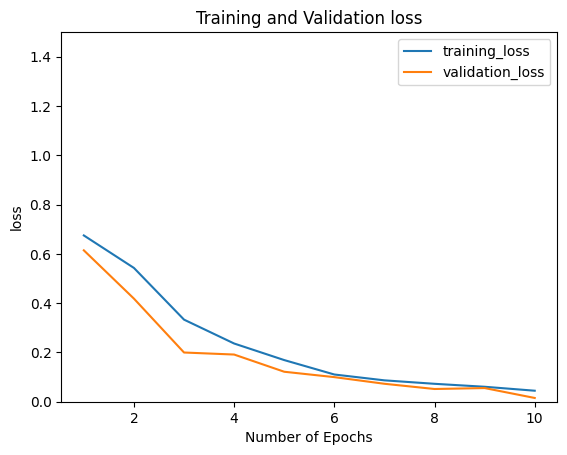

In [ ]:
plot_metric(history, 'loss')

### **3. Testing the model**

Now we can use our test set to evaluate the performance of the model.

In [ ]:
# Using moedl.evaluate() we test the model performance on unseed data which is stored in tfdataset_test
benchmarks = model.evaluate(tfdataset_test, return_dict=True, batch_size=BATCH_SIZE,verbose=1)
print(benchmarks)

4/4 [==============================] - 8s 2s/step - loss: 0.0072 - accuracy: 1.0000
{'loss': 0.007204835768789053, 'accuracy': 1.0}


- It can be noted that, the performance of model on training, validation, testing dataset is more or less the same, which is a sign of good model.
- In this way, we can see how efficiently DistilBERT acheives accuracy of 99% on test data and 98 % on training data

### **Step 4. Using the fine-tuned model to predict new samples**

Now that we've trained the model, we can use it to predict new samples. Below is a function whose output is a classifier we can use for predictions:

In [ ]:
def create_predictor(model, model_name, max_len):
  tokenizer = DistilBertTokenizer.from_pretrained(model_name)
  def predict_proba(text):
      x = [text]

      encodings = construct_encodings(x, tokenizer, max_len=max_len)
      tfdataset = construct_tfdataset(encodings)
      tfdataset = tfdataset.batch(1)

      preds = model.predict(tfdataset).logits
      #print("pred logits: ",preds)
      preds = activations.softmax(tf.convert_to_tensor(preds)).numpy()
      #print("softmax o/p: ",preds)
      return preds[0][1]

  return predict_proba



In [ ]:
clf = create_predictor(model, MODEL_NAME, MAX_LEN)
print(clf("Great product, I'm enjoying it!"))

1/1 [==============================] - 2s 2s/step
0.9957146


### **Step 5. Saving and loading the model for future use**

We use the built-in [save](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.save_pretrained) and [load](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.from_pretrained) methods from 🤗Transformers to serialize the model and restore it for future use:


In [ ]:
model.save_pretrained('./model/clf')
with open('./model/info.pkl', 'wb') as f:
    pickle.dump((MODEL_NAME, MAX_LEN), f)

We save `MODEL_NAME` and `MAX_LEN` for tokenizing/formatting down the line. Below we see how to reload the model for future use:

In [ ]:
new_model = TFDistilBertForSequenceClassification.from_pretrained('./model/clf')
model_name, max_len = pickle.load(open('./model/info.pkl', 'rb'))

clf = create_predictor(new_model, model_name, max_len)
print(clf('Love my Echo!'))

clf = create_predictor(new_model, model_name, max_len)
print(clf("Alexa doesn't get connected well to my laptop's bluetooth, however it's very useful and answers correctly to my questions"))

clf = create_predictor(new_model, model_name, max_len)
print(clf("Gets disconnecetd again and again, I'll not recommend it to others"))


Some layers from the model checkpoint at ./model/clf were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at ./model/clf and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


1/1 [==============================] - 2s 2s/step
0.9955713
1/1 [==============================] - 2s 2s/step
0.26944527
1/1 [==============================] - 0s 76ms/step
0.006418532


### Human in the Loop
- Note above function returns the probability of belonging to class 1 (i.e. Positive review)

- Now, consider for a given business scenario, you want to identify neutral reviews. May be neutral reviews aren't so helpful, or indicate just a moderate performance of a product.

- This can be acheived by playing with the threshold/ cut-off value.

- Only reviews with predicted_porbability> 0.75 (or 0.80) can be classified as positive, reviews  with predicted probability between 0.25 to 0.75 can be classified as Neutral and reviews with predicted_probability less than 0.25 can be classified as negative

In [ ]:
def predict_y_pred(predicted_probability):
  y_pred='Negative'
  if predicted_probability>= 0.75:
    y_pred='Positive'
  elif predicted_probability>0.25 and predicted_probability<0.75:
    y_pred='Neutral'
  return y_pred


In [ ]:
new_model = TFDistilBertForSequenceClassification.from_pretrained('./model/clf')
model_name, max_len = pickle.load(open('./model/info.pkl', 'rb'))

clf = create_predictor(new_model, model_name, max_len)
print('Review: Love my Echo!')
predicted_proba=clf('Love my Echo!')
print(predict_y_pred(predicted_proba))

clf = create_predictor(new_model, model_name, max_len)
print("Review: Alexa doesn't get connected well to my laptop's bluetooth, however it's very useful and answers correctly to my questions")
predicted_proba=clf("Alexa doesn't get connected well to my laptop's bluetooth, however it's very useful and answers correctly to my questions")
print(predict_y_pred(predicted_proba))

clf = create_predictor(new_model, model_name, max_len)
print("Review: Gets disconnecetd again and again, I'll not recommend it to others")
predicted_proba=clf("Gets disconnecetd again and again, I'll not recommend it to others")
print(predict_y_pred(predicted_proba))

Some layers from the model checkpoint at ./model/clf were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at ./model/clf and are newly initialized: ['dropout_59']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Review: Love my Echo!
1/1 [==============================] - 2s 2s/step
Positive
Review: Alexa doesn't get connected well to my laptop's bluetooth, however it's very useful and answers correctly to my questions


1/1 [==============================] - 2s 2s/step
Neutral
Review: Gets disconnecetd again and again, I'll not recommend it to others
1/1 [==============================] - 0s 77ms/step
Negative


**References**

Original notebook made by Rutuja Sanjay Dhanawade.